In [2]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# statistical modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

In [25]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='chesterish')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='notebook', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# reset default matplotlib rcParams
#jtplot.reset()

# 4. Stationarize a time series

Before models for forecasting can be applied, the series must be transformed into a stationary time series. The <strong>Augmented-Dickey Fuller Test</strong> can be used to test whether or not a given time series is stationary. The null hypothesis is that there is at least one <strong>unit root</strong> present in the data. 

If the test statistic is smaller than the critical value, the hypothesis is rejected, the series would be stationary, and no further transformations of the data would be required. A standalone version of the Dickey Fuller test is provided with function <code>test_for_Stationarity</code>

In [26]:
# load passenger data set and save to DataFrame
df = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')
y = df['n_passengers']

In [27]:
def test_for_stationarity(y):
    # perform Augmented Dickey Fuller test
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [28]:
test_for_stationarity(y)

Results of Augmented Dickey-Fuller test:
test statistic           0.81537
p-value                  0.99188
# of lags               13.00000
# of observations      130.00000
Critical Value (1%)     -3.48168
Critical Value (5%)     -2.88404
Critical Value (10%)    -2.57877
dtype: float64


Because the test statistic is above the 5% critical value and the p-value is larger than 0.05, (the moving average is not constant over time) and the null hypothesis of the Augmented Dickey-Fuller test cannot be rejected, the series is not stationary.



For this section, the function <code>ts_diagnostics</code> is introduced to monitor the effort of stationarizing the time series. It includes the rolling mean and standard deviation of a time series with a twelve month window, the ACF, PACF, QQ Plot, histogram, and computes the Augmented-Dickey Fuller Test.

In [29]:
def ts_diagnostics(y, lags=None, title=''):
    '''
    Calculate acf, pacf, qq plot and Augmented Dickey Fuller test for a given time series
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    # weekly moving averages (5 day window because of workdays)
    rolling_mean = pd.rolling_mean(y, window=12)
    rolling_std = pd.rolling_std(y, window=12)
    
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    rolling_mean.plot(ax=ts_ax, color='crimson');
    rolling_std.plot(ax=ts_ax, color='darkslateblue');
    plt.legend(loc='best')
    ts_ax.set_title(title);
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    plt.show()
    
    # perform Augmented Dickey Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return 

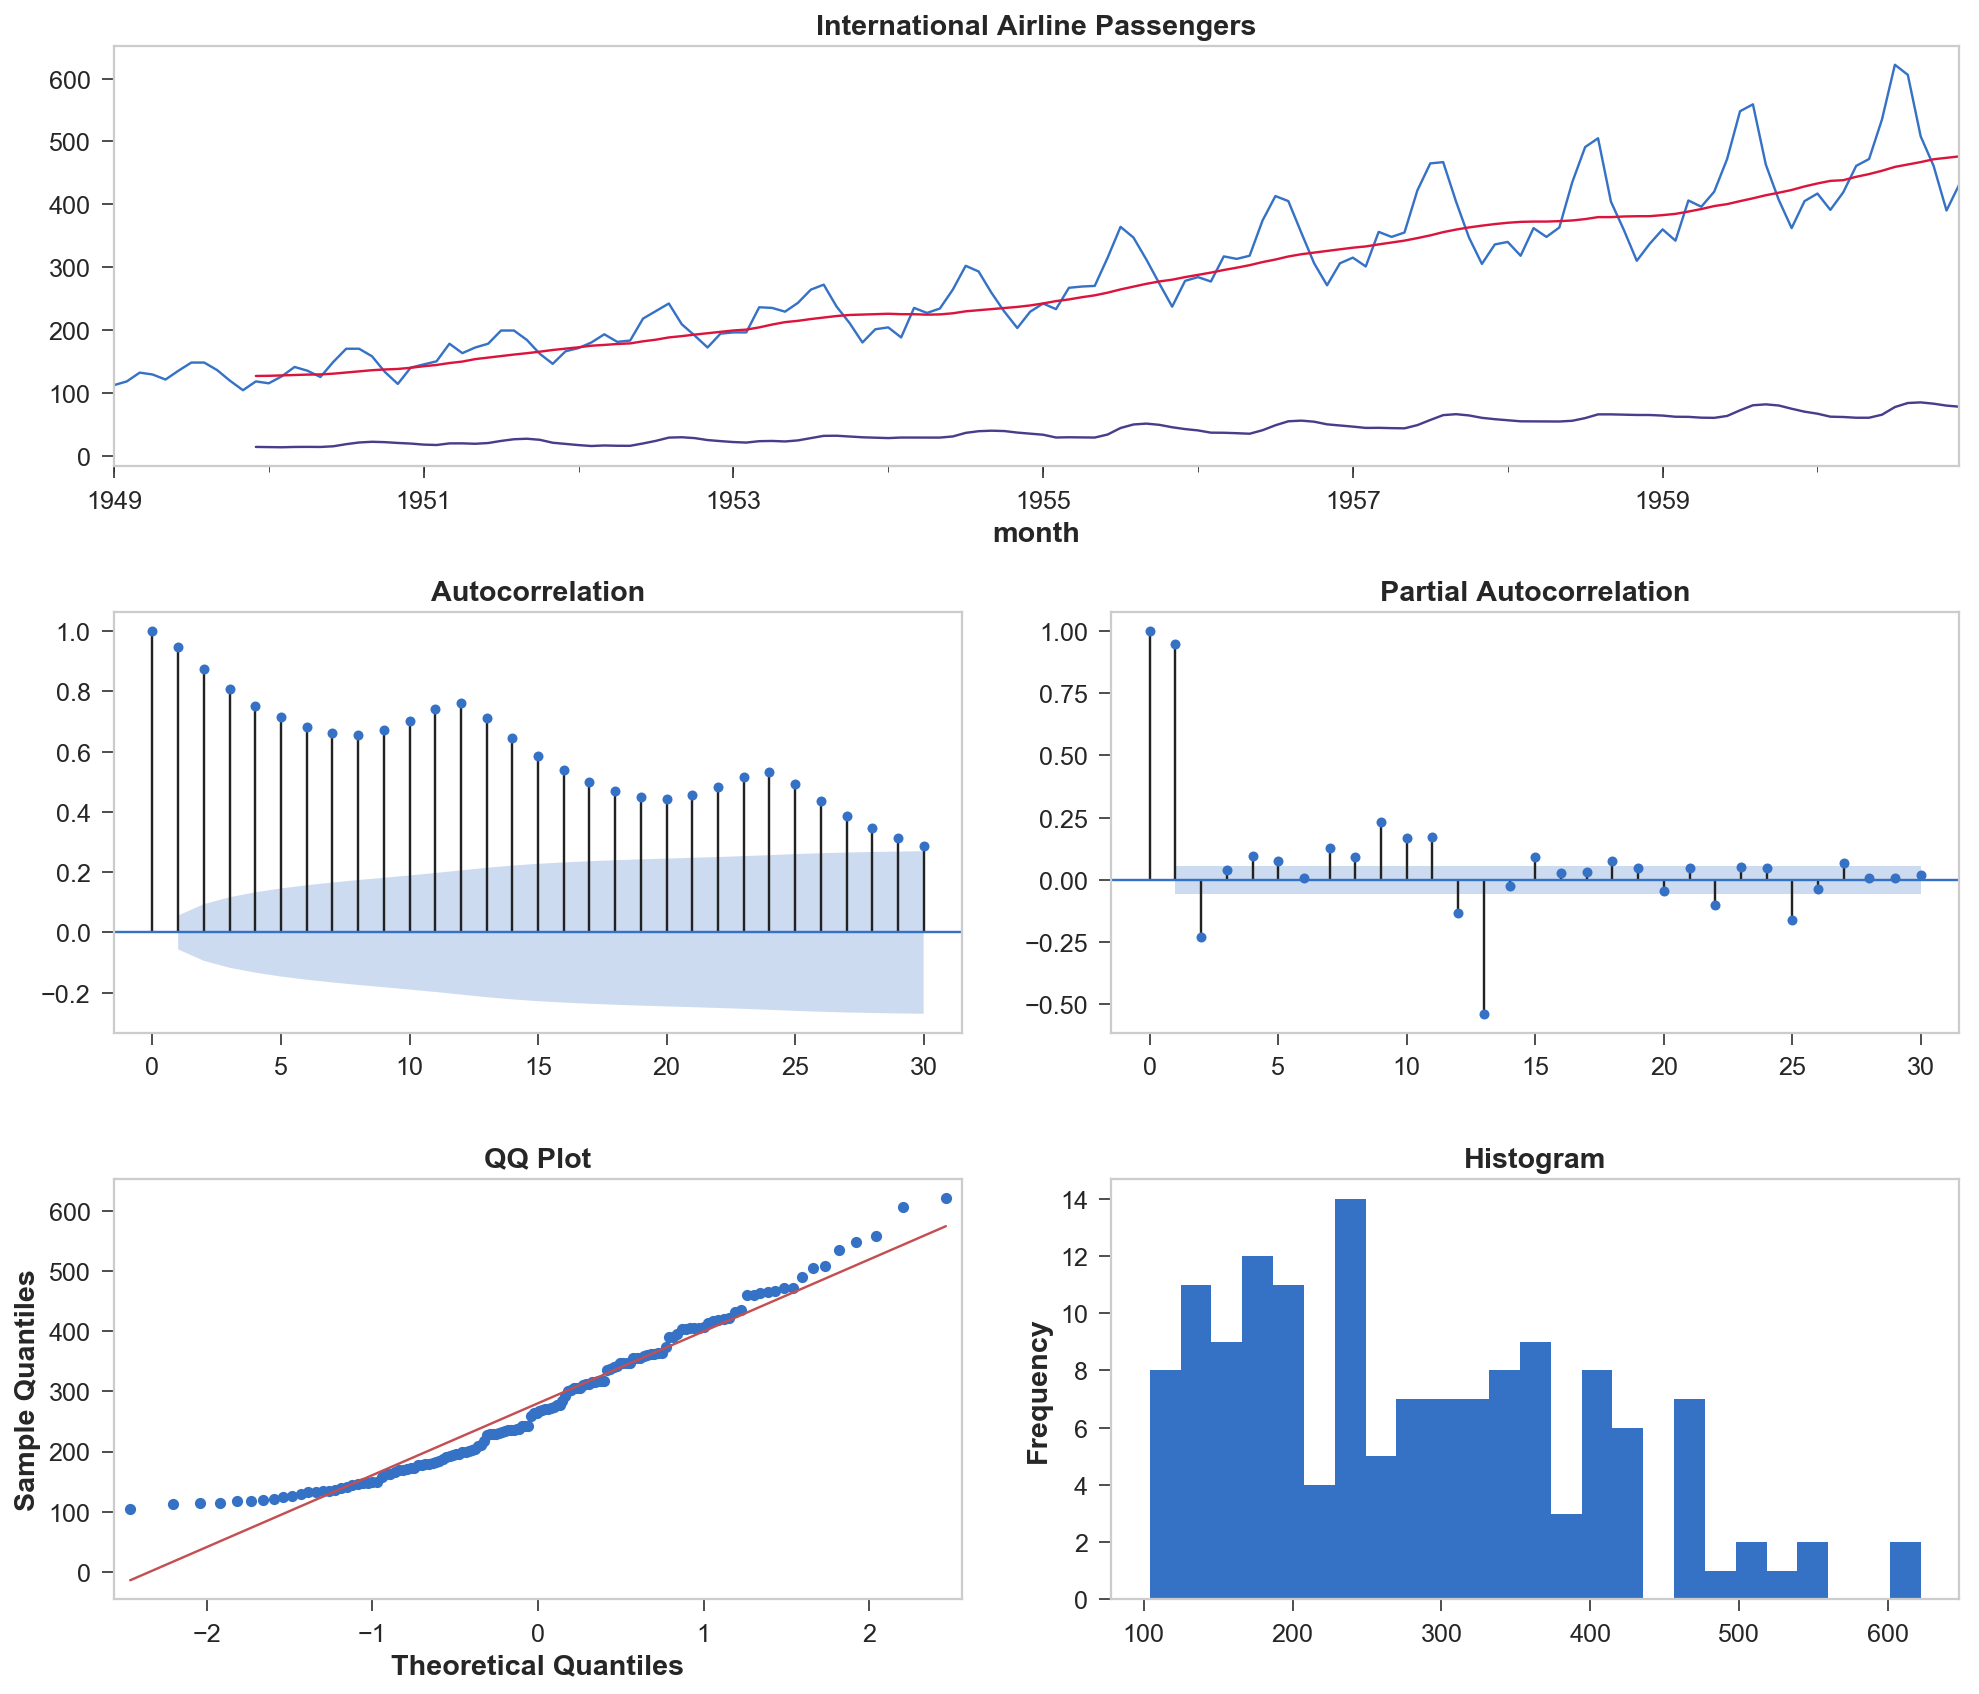

Results of Dickey-Fuller test:
test statistic           0.81537
p-value                  0.99188
# of lags               13.00000
# of observations      130.00000
Critical Value (1%)     -3.48168
Critical Value (5%)     -2.88404
Critical Value (10%)    -2.57877
dtype: float64


In [30]:
ts_diagnostics(y, lags=30, title='International Airline Passengers')

<strong>Inference</strong>
<ul>
<li>Application of the log transformation resulted in less variation of the processes variance</li>
<li>Process is still not stationary, since test statistic is larger than the critical value</li>
</ul>

## 4.1 First difference

The first difference is used to make a time series <strong>trend</strong> or <strong>mean stationary</strong>. A first difference can be applied applied by

$$ 
y'_t = y_t - y_{t-1}
$$

In [31]:
y_diff = np.diff(y)

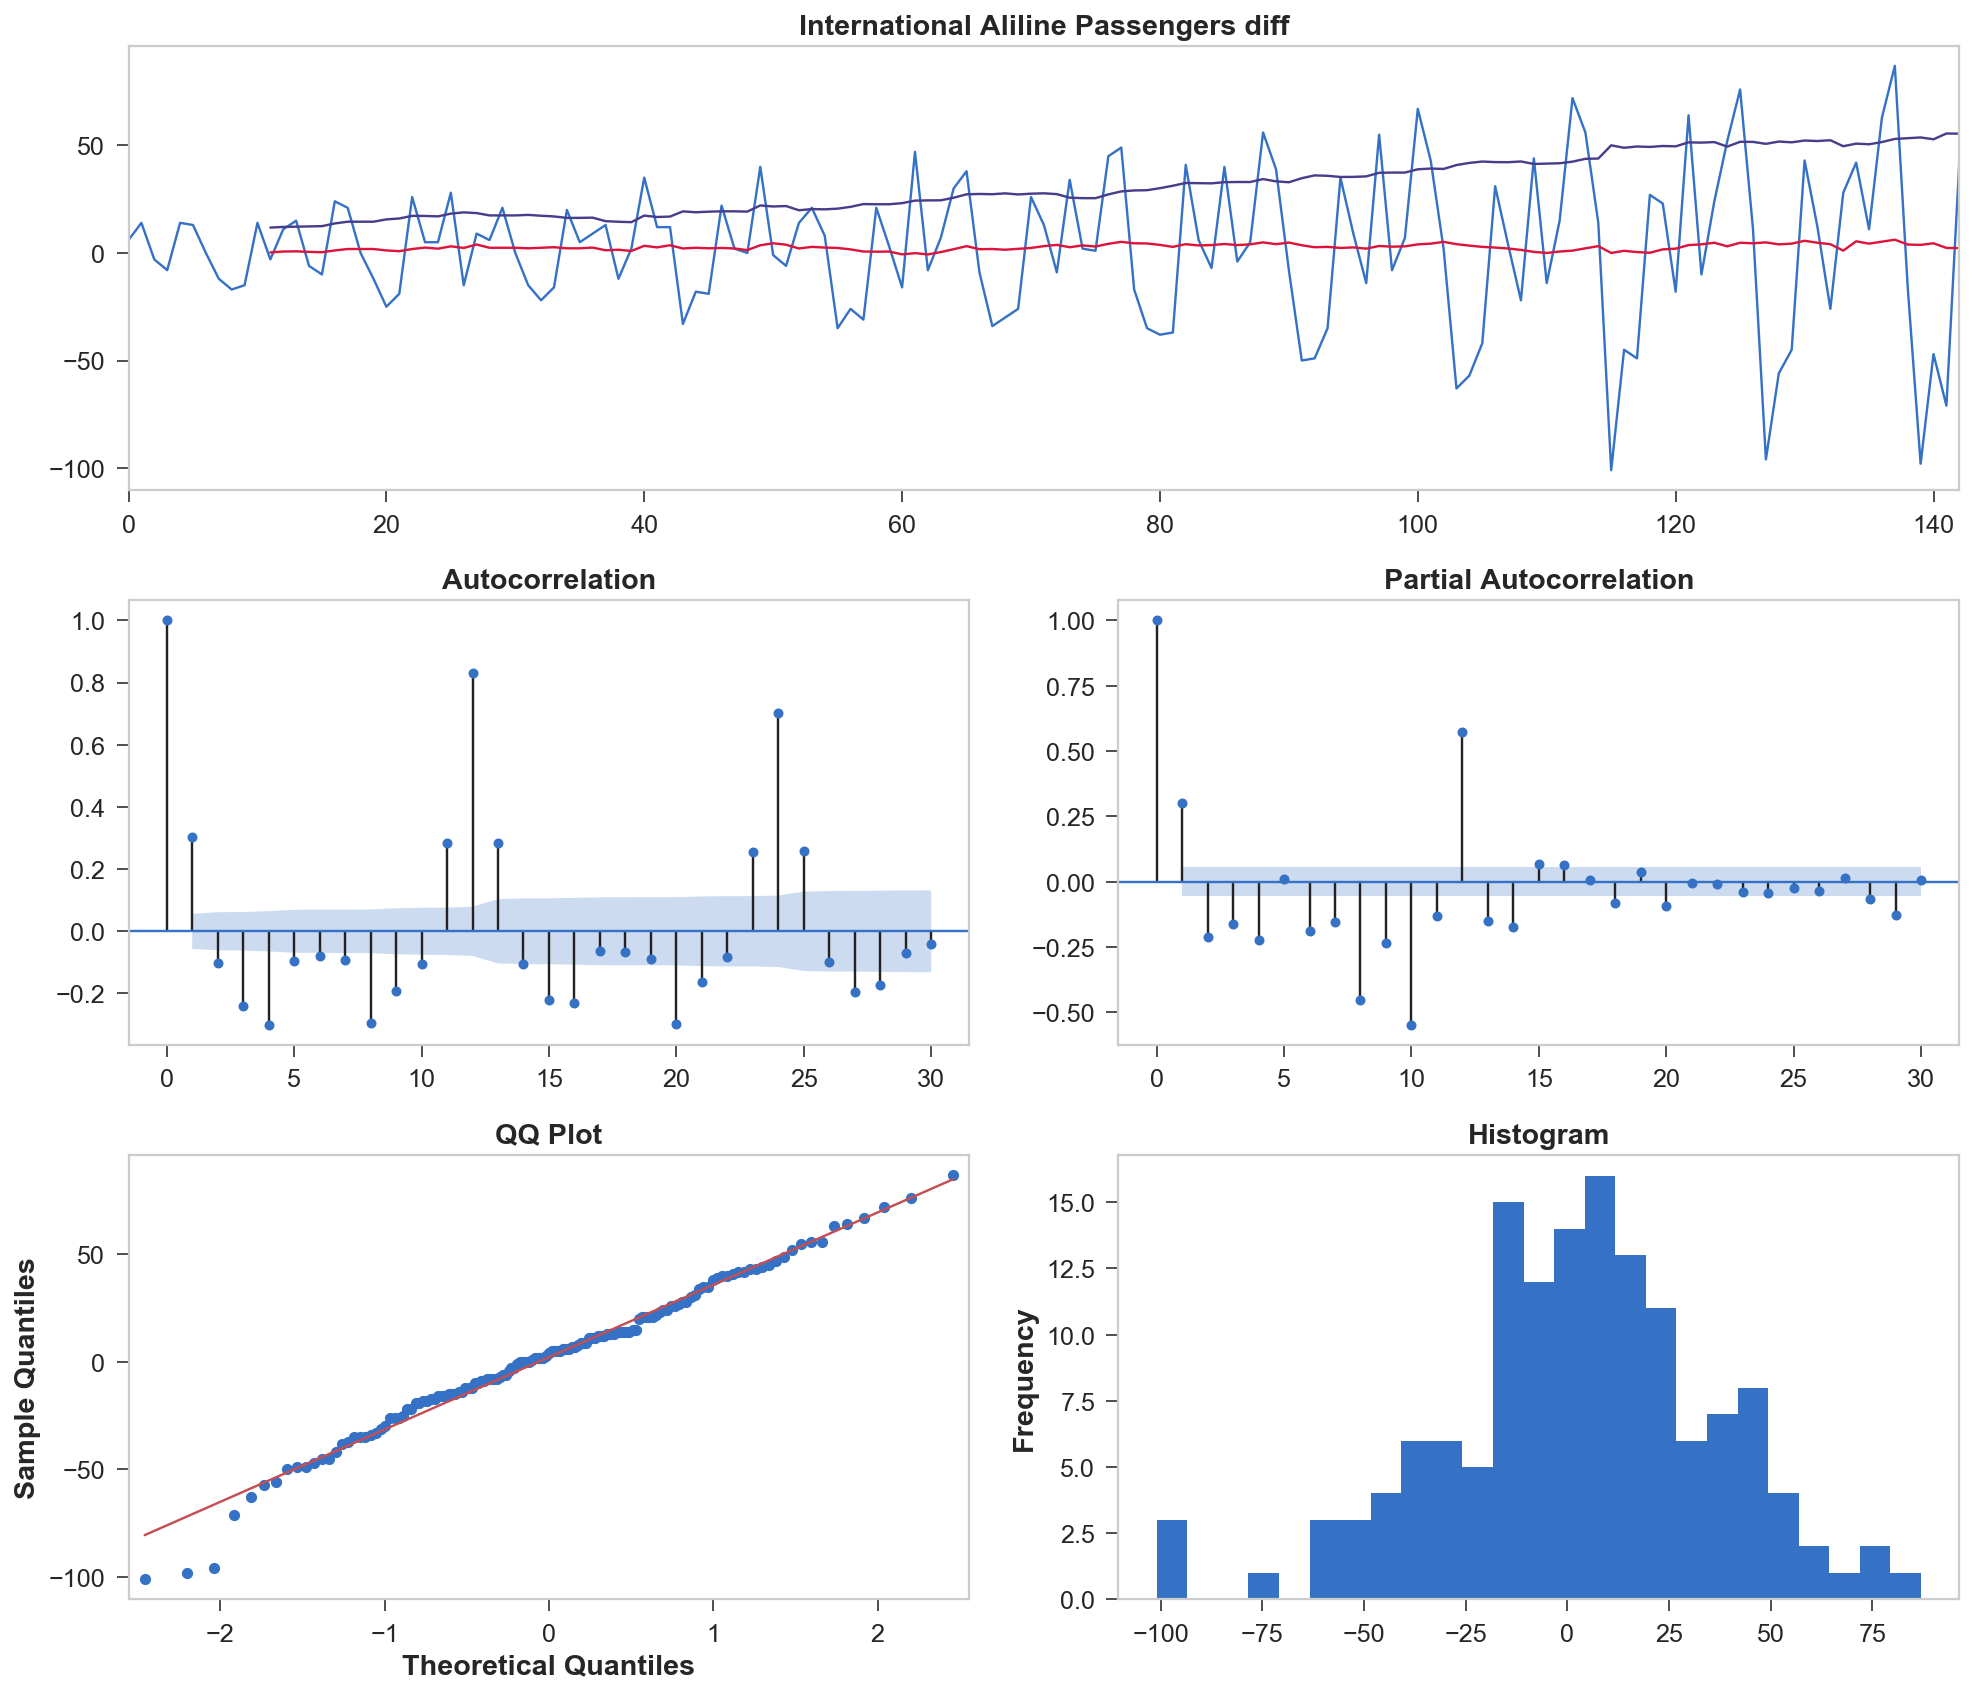

Results of Dickey-Fuller test:
test statistic          -2.82927
p-value                  0.05421
# of lags               12.00000
# of observations      130.00000
Critical Value (1%)     -3.48168
Critical Value (5%)     -2.88404
Critical Value (10%)    -2.57877
dtype: float64


In [32]:
ts_diagnostics(y_diff, lags=30, title='International Aliline Passengers diff')

<strong>Inference</strong>
<ul>
<li>Improvement for the Dickey Fuller test statistic, but process is still not stationary as indicated by the dark blue line (time dependent variance)</li>
<li>Serial correlation has been reduced, however, there are still spikes in ACF and PACF plots</li>
<li>Mean appears mean stationary around 0 (red line).</li>
</ul>

## 4.2 Log transformation

The log transformation is used to make a time series <strong>variance stationary</strong>, that is stabalizing the variance for the complete time series

$$
y^{log}_t = log(y_t)
$$

Note, that the series will not be stationary on the mean since the original data and not the differenced data is used here

In [23]:
y_log = np.log(y)

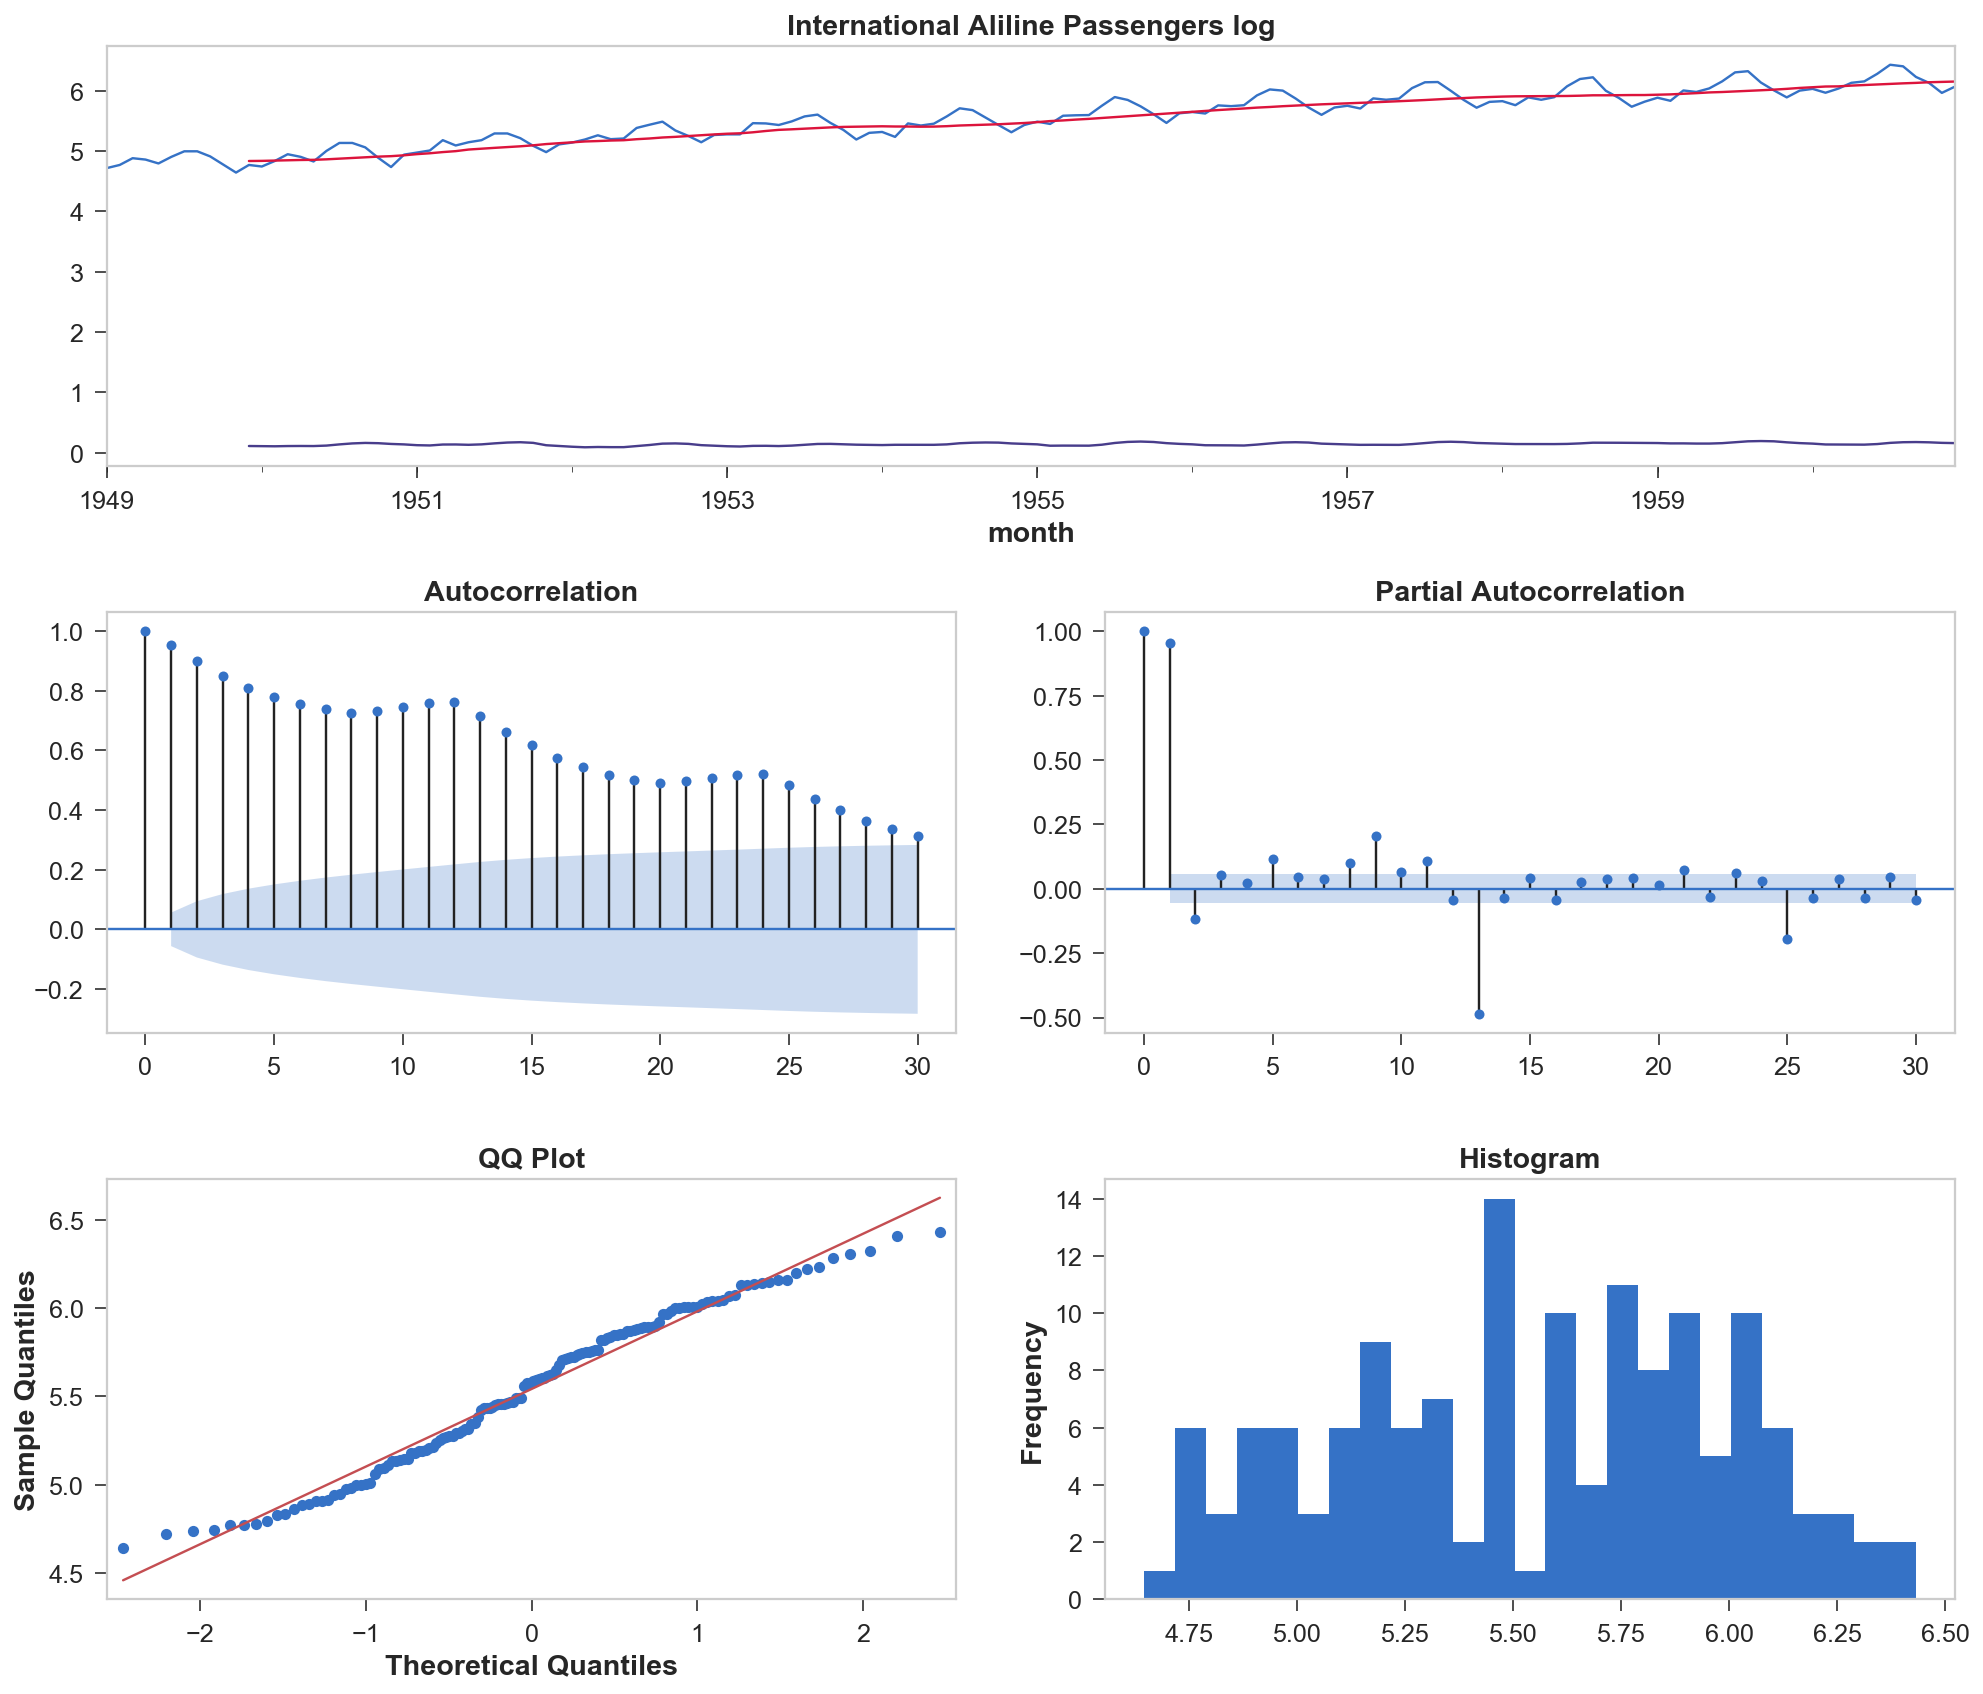

Results of Dickey-Fuller test:
test statistic          -1.71702
p-value                  0.42237
# of lags               13.00000
# of observations      130.00000
Critical Value (1%)     -3.48168
Critical Value (5%)     -2.88404
Critical Value (10%)    -2.57877
dtype: float64


In [24]:
ts_diagnostics(y_log, lags=30, title='International Aliline Passengers log')

<strong>Inference</strong>
<ul>
<li>Application of the log transformation resulted in less variation of the processes variance</li>
<li>Process is still not stationary, since test statistic is larger than the critical value</li>
<li>Strong serial correlation rmains within the series</li>
<li>The errors do not appear do be normally distributed</li>
</ul>

## 4.3 Log transformed first order difference

$$
y'_t = log(y_t) - log(y_{t-1})
$$

In [9]:
y_log_diff = np.log(y).diff().dropna()

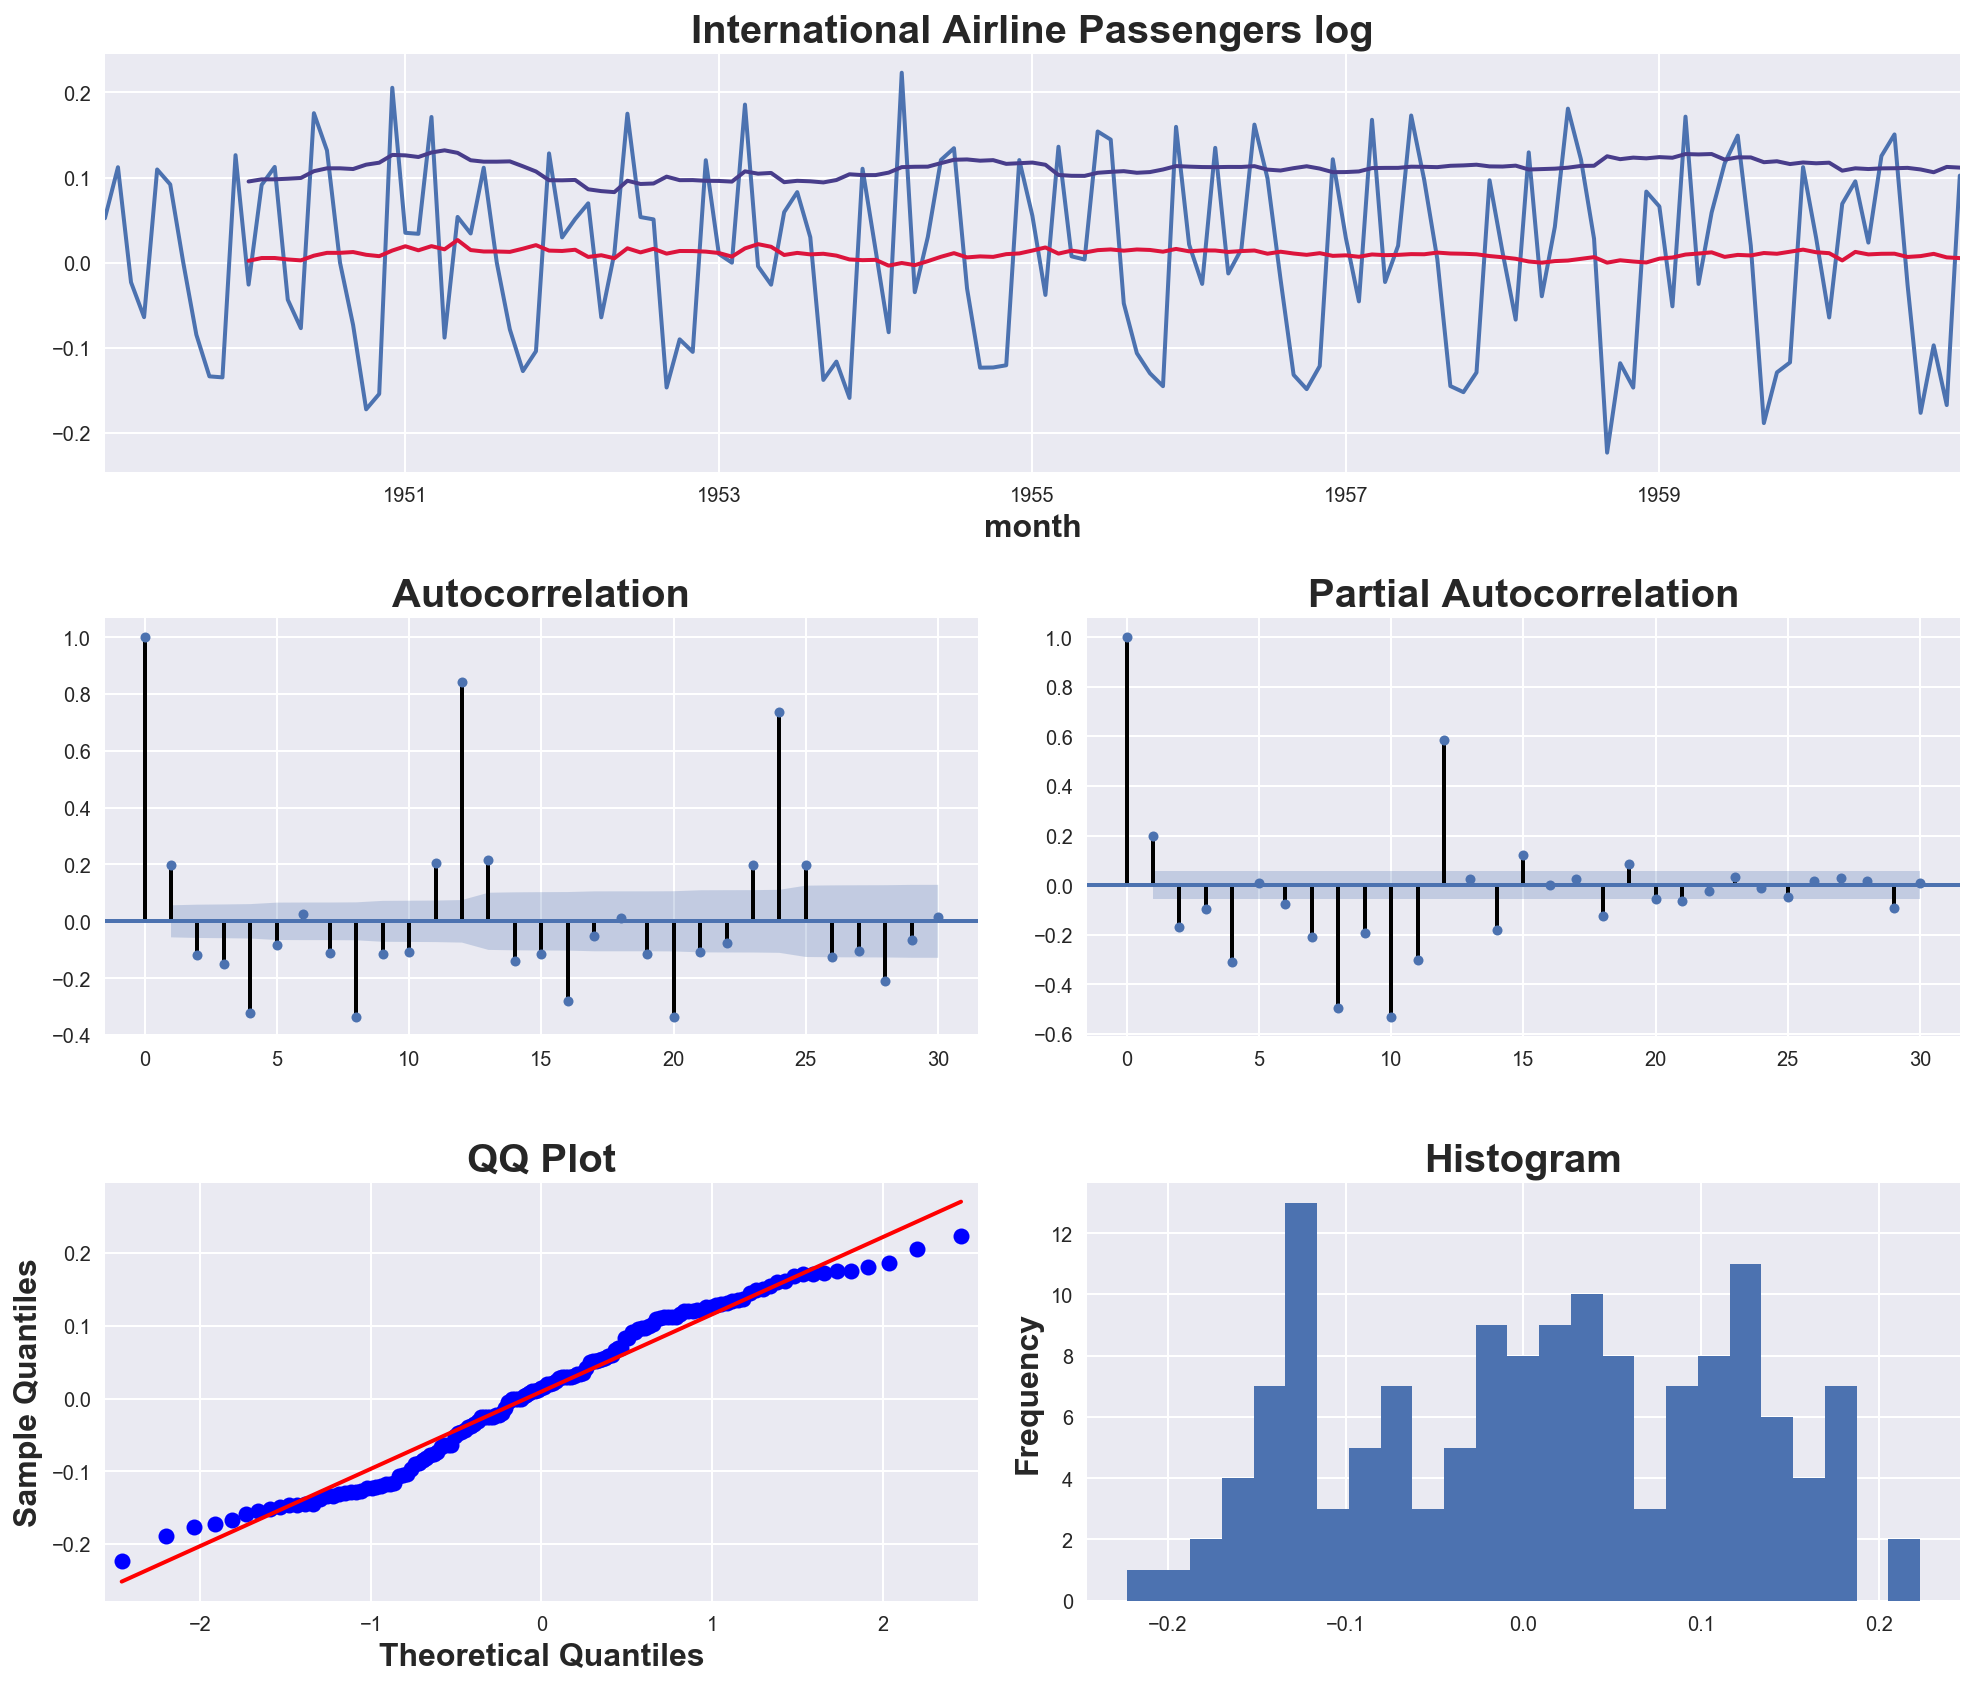

Results of Dickey-Fuller test:
test statistic          -2.71713
p-value                  0.07112
# of lags               14.00000
# of observations      128.00000
Critical Value (10%)    -2.57896
Critical Value (1%)     -3.48250
Critical Value (5%)     -2.88440
dtype: float64


In [10]:
ts_diagnostics(y_log_diff, lags=30, title='International Airline Passengers log')

<strong>Inference</strong>
<ul>
<li>Application of the first difference seems to have extracted the trend pattern</li>
<li>However, the process is still not stationary, since test statistic is larger than the critical value</li>
<li>The plotted series can now be interpreted as percentages changes per month</li>
</ul>


## 4.4 Log transformed second order difference

Sicne the time series is still not stationary (as indicated by the Dickey-Fuller test) another differencing step can be included.

In [11]:
y_log_diff2 = np.log(y).diff().diff(12).dropna()

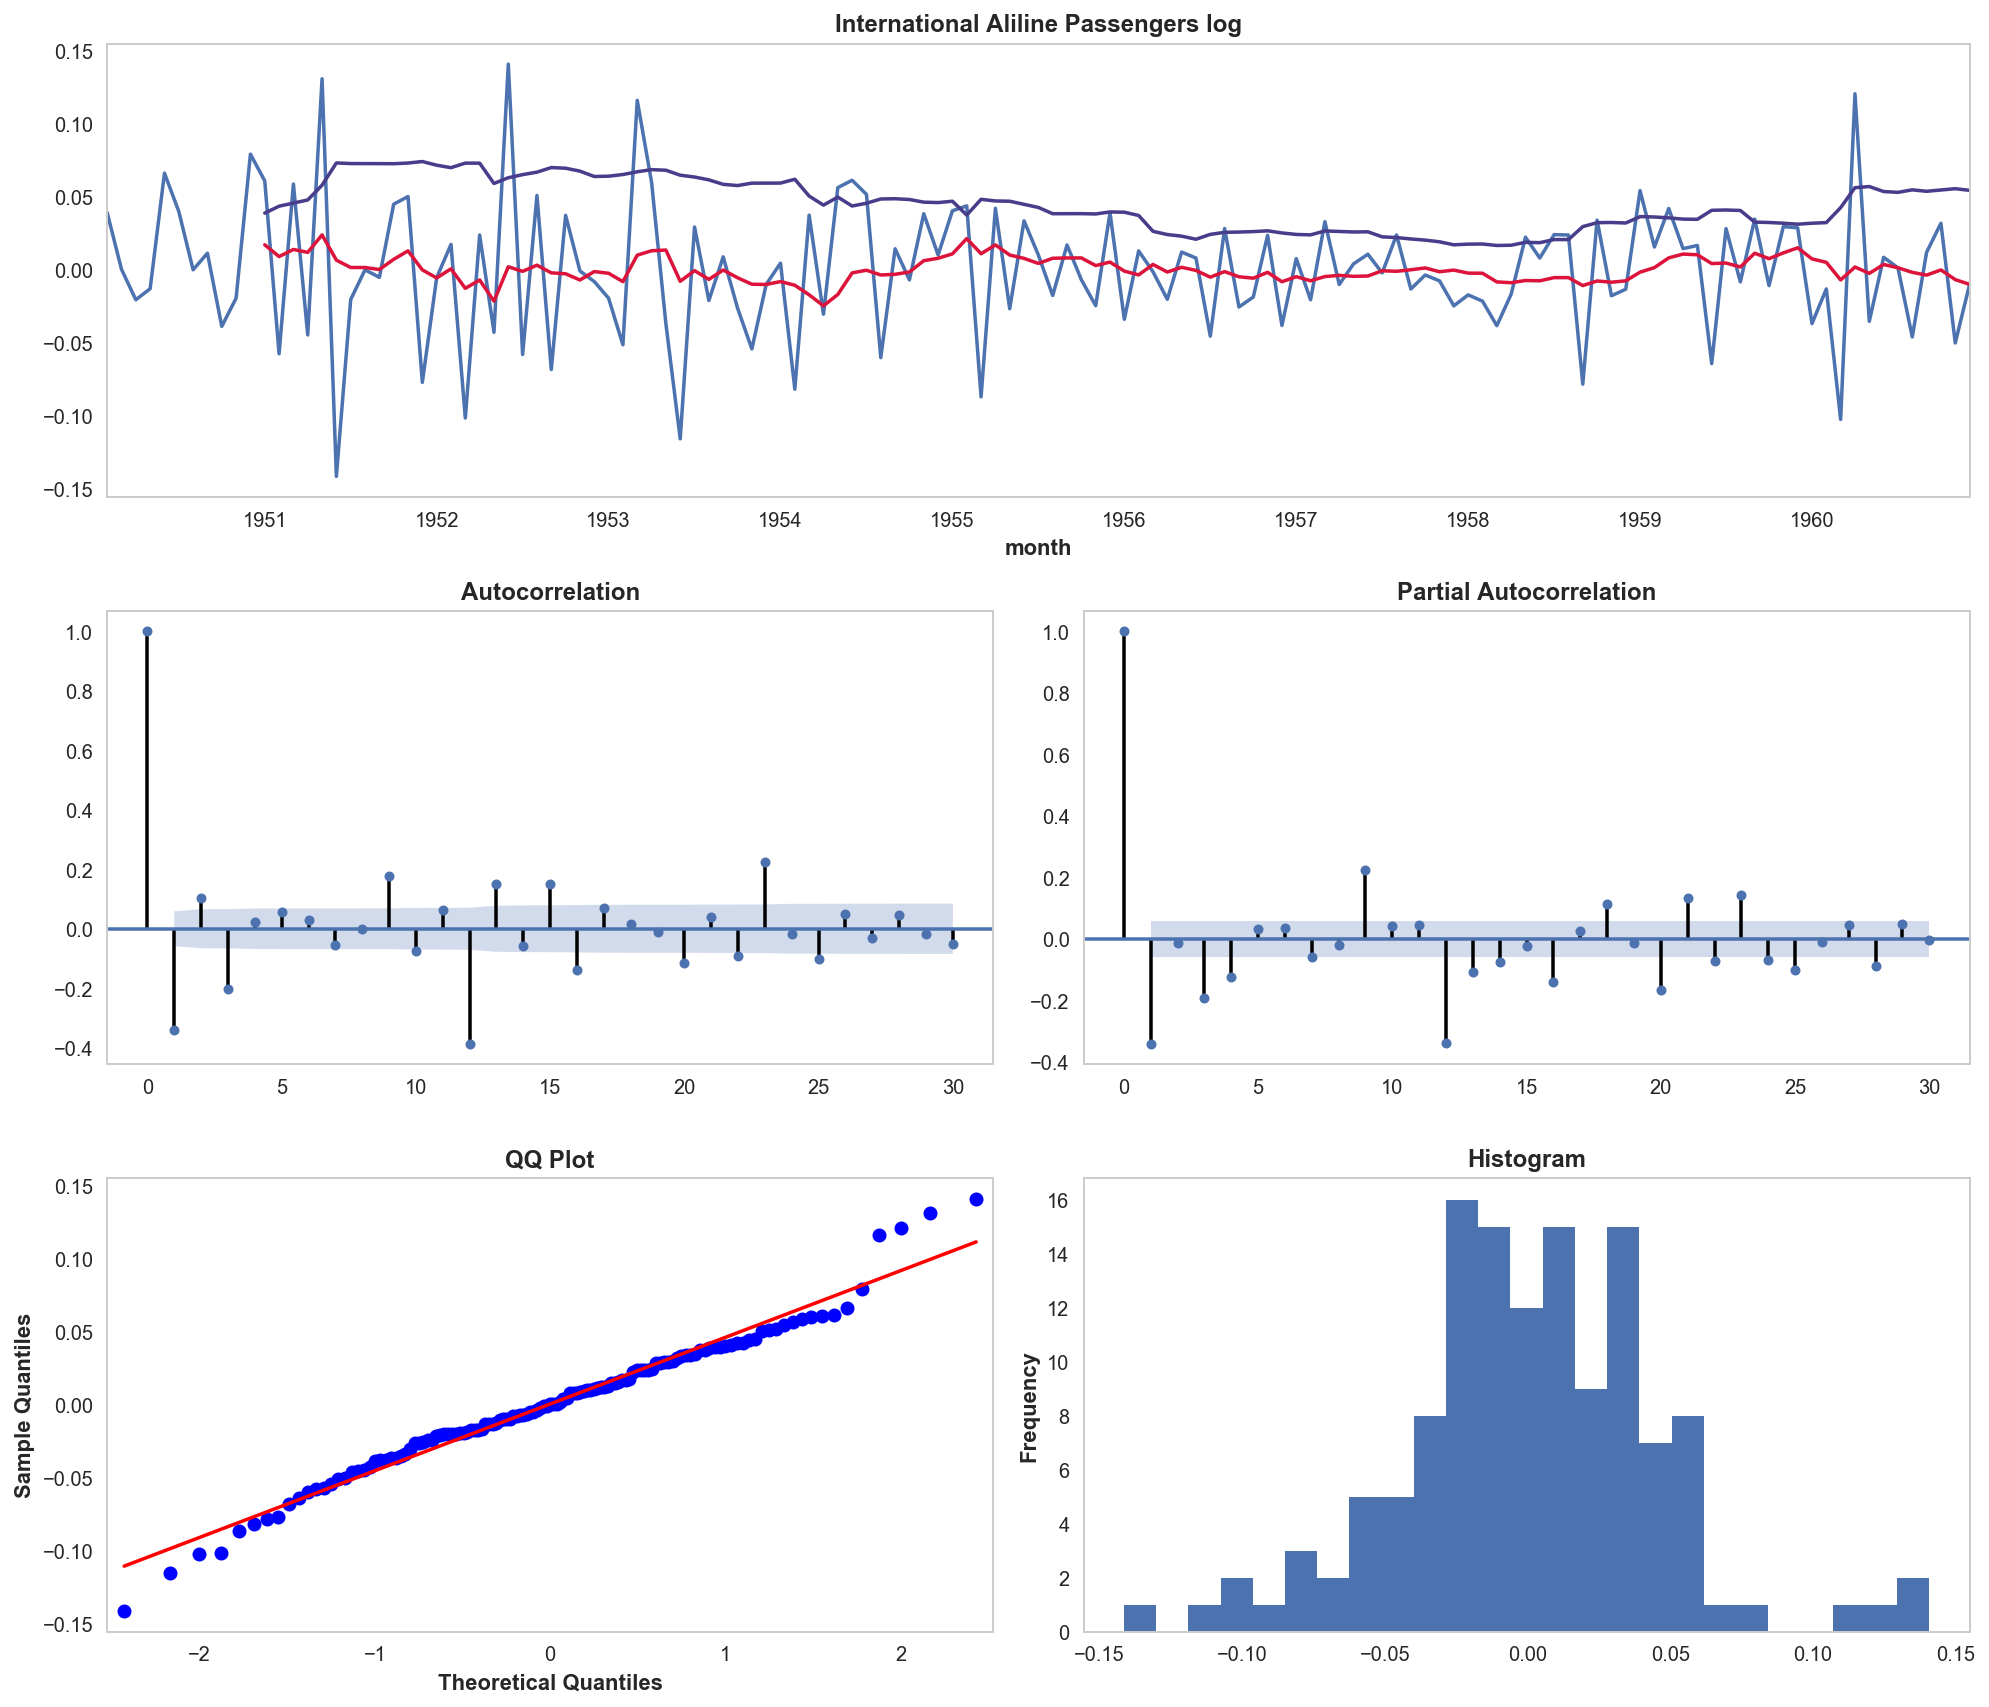

Results of Dickey-Fuller test:
test statistic          -4.44332
p-value                  0.00025
# of lags               12.00000
# of observations      118.00000
Critical Value (1%)     -3.48702
Critical Value (5%)     -2.88636
Critical Value (10%)    -2.58001
dtype: float64


In [12]:
ts_diagnostics(y_log_diff2, lags=30, title='International Aliline Passengers log diff')

Since there are spikes in the ACF and PACF plots which lie outsight the insignifcant zone it can be concluded that the residuals are still not random. This implies that there is an information pattern left in the residuals which can be extracted by <strong>autoregressive</strong> and <strong>moving average</strong> models.

When looking at the PACF and ACF plot of the log transformed second order differenced time series a significant spike in the residuals at lag 12 can be detected. This is an indication for the seasonal component, which as not been extracted from the series completely. Overall, this preliminary result makes sense, since the analyzed data has a monthly frequency that tends to have a seasonality of 12 months.

## 4.5 Exercise

Analyse any of the time series in the stock data set. What transformations are needed to make the series stationary according to the Dickey Fuller test for stationarity?